# Detecting bats by recognizing sound with Tensorflow
Last week I discovered that there are bats behind my appartment. I immediately grabbed my "bat detector": a device that converts the ultrasound signals bats use to echolocate from an inaudible frequency range to an audible one. The name "bat detector" thus is a lie: you can use it to detect bats, but it does not detect bats itself. In this tutorial I will show you how to build a real bat detector using Tensorflow. 

![Me and my girlfriend listening to bats](http://www.pinchofintelligence.com/wp-content/uploads/2017/08/DE4fqUoXUAAnU42-1.jpg) ![My bat detector](http://www.pinchofintelligence.com/wp-content/uploads/2017/08/batdetector.png)

## Problem statement
To approach this problem I hooked up the bat detector to my laptop and recorded several clips. In a [seperate Jupyter notebook I created a labeling program](https://github.com/rmeertens/batdetection/blob/master/Label%20data.ipynb). This program creates "soundbites" of one second, which I classified as either containing the sound of a bat, or not containing the sound of a bat. I take the data and labels to create a classifier that can distinguish them. 

## Libraries to recognize sound

There are some very useful libraries I imported to be able to build a sound recognition pipeline. Obvious libraries I imported are Tensorflow, Keras, and scikit. A sound-specific library I like is [librosa](https://github.com/librosa/librosa), which helps me load and analyze the data.

In [1]:
import random
import sys
import glob
import os
import time

import IPython
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

import librosa
import librosa.display

from sklearn.preprocessing import normalize
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

Using TensorFlow backend.


## Loading sound data with Python
In the data labeling notebook we typed in labels, and saved soundbytes to the folder we typed in. By loading from these folders I can load bat sounds and non-batsound files. Depending on how many soundfiles there are loading this data can take a long time. 

In [2]:
# Note: SR stands for sampling rate, the rate at which my audio files were recorded and saved. 
SR = 22050 # All audio files are saved like this

def load_sounds_in_folder(foldername):
    """ Loads all sounds in a folder"""
    sounds = []
    for filename in os.listdir(foldername):
        X, sr = librosa.load(os.path.join(foldername,filename))
        assert sr == SR
        sounds.append(X)
    return sounds

## Sounds in which you can hear a bat are in the folder called "1". Others are in a folder called "0". 
batsounds = load_sounds_in_folder('labeled/1')
noisesounds = load_sounds_in_folder('labeled/0')

print("With bat: %d without: %d total: %d " % (len(batsounds), len(noisesounds), len(batsounds)+len(noisesounds)))
print("Example of a sound with a bat:")
IPython.display.display(IPython.display.Audio(random.choice(batsounds), rate=SR,autoplay=True))
print("Example of a sound without a bat:")
IPython.display.display(IPython.display.Audio(random.choice(noisesounds), rate=SR,autoplay=True))

With bat: 96 without: 1133 total: 1229 
Sound with a bat:


Sound without a bat:


An example of a sound with a bat is: 

An example of a sound without a bat is: 

## Visualizing sounds with Librosa
When listening to the bats with your headphones you can hear a clear noise when one flies by. The Librosa library can perform a [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) to extract the frequencies the sound is composed of. 
Before building any machine learning algorithm it is very important to carefully inspect the data you are dealing with. In this case I decided to:
  - listen to the sounds
  - plot the soundwave
  - plot the [spectogram (a visual representation of the amplitude of frequencies through time)](https://en.wikipedia.org/wiki/Spectrogram). 
  

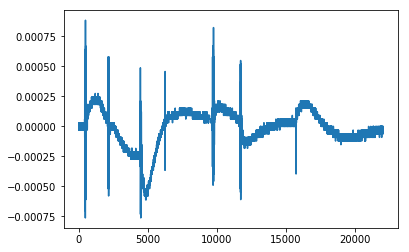

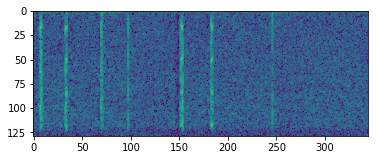

Length per sample: 22050, shape of spectogram: (129, 345), max: -22.786959 min: -100.000000


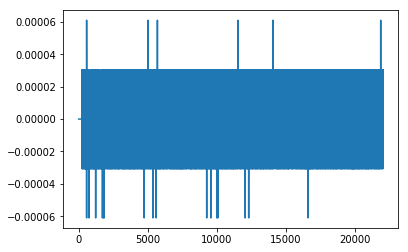

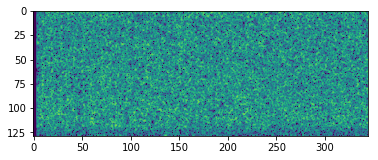

Length per sample: 22050, shape of spectogram: (129, 345), max: -58.154167 min: -100.000000


In [3]:
def get_short_time_fourier_transform(soundwave):
    return librosa.stft(soundwave, n_fft=256)

def short_time_fourier_transform_amplitude_to_db(stft):
    return librosa.amplitude_to_db(stft)

def soundwave_to_np_spectogram(soundwave):
    step1 = get_short_time_fourier_transform(soundwave)
    step2 = short_time_fourier_transform_amplitude_to_db(step1)
    step3 = step2/100
    return step3

def inspect_data(sound):
    plt.figure()
    plt.plot(sound)
    IPython.display.display(IPython.display.Audio(sound, rate=SR))
    a = get_short_time_fourier_transform(sound)
    Xdb = short_time_fourier_transform_amplitude_to_db(a)
    plt.figure()
    plt.imshow(Xdb)
    plt.show()
    print("Length per sample: %d, shape of spectogram: %s, max: %f min: %f" % (len(sound), str(Xdb.shape), Xdb.max(), Xdb.min()))

inspect_data(batsounds[0])
inspect_data(noisesounds[0])

## Data analysis
### Small data problem, with imbalanced samples
First of all it's important to note that the data we are dealing with is not exactly big data... With only around 100 positive samples, deep neural networks are very likely to overfit on this daa. A problem we are dealing with is that it is easy to gather negative samples (just record a whole day without bats) and difficult to gather positive samples (bats are only here for about 15-20 minutes a day, and I need to manually label data). The low amount of positive samples is something we take into consideration when determining how we are going to classify the data. 

### Audio signal
As we can see above the amplitude of the signal is low with the noise, while the signal has high amplitudes. However, this does not mean that everything with a sound in it is a bat. At this frequency you also pick up other noises, such as rubbing your fingers together or telephone signals. 
I decided to put every negative signal onto one big "negative" pile, combining telephone signals, finger-induced noise, and other stuff in one big pile. 

### Spectrogram
I was hoping the see the exact frequency bats produce back in our spectogram. Unfortunately it looks like my sensor picks it up as noise over ALL frequencies. Looking at the spectrogram you can still see a clear difference between bat-sound and noise. 

In the end I decided to go with a "metadata approach". I divide every second of sound in 22 parts. For each part I determine the max, min, mean, standard deviation, and max-min of the sample. The reason I take this approach is because the "bat signals" DO clearly show up as a not of high-amplitude signals in the audio visualisation. By analyzing different parts of the audio signal, I can find out if multiple parts of the signal have certain features (such as a high standard deviation), and thus detect a bat call. 
![Preprocessing idea](http://www.pinchofintelligence.com/wp-content/uploads/2017/08/download-20.png)

In [4]:
WINDOW_WIDTH = 10
AUDIO_WINDOW_WIDTH = 1000 # With sampling rate of 22050 we get 22 samples for our second of audio
def audio_to_metadata(audio):
    """ Takes windows of audio data, per window it takes the max value, min value, mean and stdev values"""
    features = []
    for start in range(0,len(audio)-AUDIO_WINDOW_WIDTH,AUDIO_WINDOW_WIDTH):
        subpart = audio[start:start+AUDIO_WINDOW_WIDTH]
        maxval = max(subpart)
        minval = min(subpart)
        mean = np.mean(subpart)
        stdev = np.std(subpart)
        features.extend([maxval,minval,mean,stdev,maxval-minval])
    return features

metadata = audio_to_metadata(batsounds[0])
print(metadata)
print(len(metadata))

[0.00088500977, -0.00076293945, 6.7962646e-05, 0.00010915515, 0.0016479492, 0.0002746582, 3.0517578e-05, 0.00017904663, 5.4772983e-05, 0.00024414062, 0.00057983398, -0.00057983398, -2.8137207e-05, 8.1624778e-05, 0.001159668, -9.1552734e-05, -0.0002746582, -0.00019345093, 3.922523e-05, 0.00018310547, 0.00048828125, -0.00076293945, -0.00036187744, 0.00015121402, 0.0012512207, -3.0517578e-05, -0.00057983398, -0.00027001952, 0.00015006117, 0.00054931641, 0.00045776367, -0.00036621094, 5.9234619e-05, 5.0381914e-05, 0.00082397461, 0.00015258789, 6.1035156e-05, 0.00011447143, 1.7610495e-05, 9.1552734e-05, 0.00015258789, 6.1035156e-05, 9.3963623e-05, 1.8880468e-05, 9.1552734e-05, 0.00082397461, -0.00048828125, 7.7423094e-05, 8.6975793e-05, 0.0013122559, 0.00021362305, 6.1035156e-05, 0.00014205933, 2.5201958e-05, 0.00015258789, 0.00054931641, -0.00061035156, 2.8991699e-05, 9.5112577e-05, 0.001159668, -3.0517578e-05, -0.00018310547, -0.00010638428, 2.9584806e-05, 0.00015258789, 3.0517578e-05, -9

## Data management
As with every machine learning project it's important to make an input-output pipeline. We defined functions to get "metadata" from our sound files: we can make audio spectograms, and simply take multiple samples of meta-features in the audio data. The next step is to map our preprocessing function to our training and test data. I first apply a preprocessing step to each audio sample, and keep the bat and nonbat sounds in two different lists. Later I join the sounds and labels. 

In this case we are dealing with few "positive" samples, and a lot of negative samples. In such a case it's a really good idea to normalise all your data. My positive samples will probably differ from the normal distribution, and will be easy to detect. To do this I use the [scikit learn sklearn.preprocessing function "normalize"](http://scikit-learn.org/stable/modules/preprocessing.html). During training I found out that my idea of standardization and normalization are exactly opposite of the scikit definitions. In this case this probably won't be a problem, as normalizing a bat sound probably still yields a different result than normalizing a noise sound.  

In [19]:
# Meta-feature based batsounds and their labels
preprocessed_batsounds = list()
preprocessed_noisesounds = list()

for sound in batsounds:
    expandedsound = audio_to_metadata(sound)
    preprocessed_batsounds.append(expandedsound)
for sound in noisesounds:
    expandedsound = audio_to_metadata(sound)
    preprocessed_noisesounds.append(expandedsound)

labels = [0]*len(preprocessed_noisesounds) + [1]*len(preprocessed_batsounds)
assert len(labels) == len(preprocessed_noisesounds) + len(preprocessed_batsounds)
allsounds = preprocessed_noisesounds + preprocessed_batsounds
allsounds_normalized = normalize(np.array(allsounds),axis=1)
one_hot_labels = keras.utils.to_categorical(labels)
print(allsounds_normalized.shape)
print("Total noise: %d total bat: %d total: %d" % (len(allsounds_normalized), len(preprocessed_batsounds), len(allsounds)))

## Now zip the sounds and labels, shuffle them, and split into a train and testdataset
zipped_data = zip(allsounds_normalized, one_hot_labels)
np.random.shuffle(zipped_data)
random_zipped_data = zipped_data
VALIDATION_PERCENT = 0.8 # use X percent for training, the rest for validation
traindata = random_zipped_data[0:int(VALIDATION_PERCENT*len(random_zipped_data))]
valdata = random_zipped_data[int(VALIDATION_PERCENT*len(random_zipped_data))::]
indata = [x[0] for x in traindata]
outdata = [x[1] for x in traindata]
valin = [x[0] for x in valdata]
valout = [x[1] for x in valdata]

(1229, 110)
Total noise: 1229 total bat: 96 total: 1229


## Machine learning model 
To detect the bats I decided to try a very simple neural network with three hidden layers. With too little trainable parameters the network can only make a distinction between no-sound and sound. With too many trainable parameters the network will easily overfit on the small dataset we have. 

I decided to implement this network in Keras, this libary gives me the best functions to easily try different neural network architectures on this simple problem. 

In [24]:
LEN_SOUND = len(preprocessed_batsounds[0])
NUM_CLASSES = 2 # Bat or no bat

model = Sequential()
model.add(Dense(128, activation='relu',input_shape=(LEN_SOUND,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2))
model.compile(loss="mean_squared_error", optimizer='adam', metrics=['mae','accuracy'])
model.summary()
model.fit(np.array(indata), np.array(outdata), batch_size=64, epochs=10,verbose=2, shuffle=True) 
valresults = model.evaluate(np.array(valin), np.array(valout), verbose=0)
res_and_name = zip(valresults, model.metrics_names)
for result,name in res_and_name: 
    print("Validation " + name + ": " + str(result))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 128)               14208     
_________________________________________________________________
dense_46 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_47 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_48 (Dense)             (None, 2)                 66        
Total params: 19,458
Trainable params: 19,458
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
0s - loss: 0.4304 - mean_absolute_error: 0.5098 - acc: 0.8494
Epoch 2/10
0s - loss: 0.1665 - mean_absolute_error: 0.3404 - acc: 0.9166
Epoch 3/10
0s - loss: 0.0673 - mean_absolute_error: 0.1601 - acc: 0.9166
Epoch 4/10
0s - loss: 0.0584 - mean_absolute_error:

## Results and implementation of detection pipeline
With an accuracy of 95 percent on the validation set it looks like we are doing really well. The next step is checking if we can any bats in a longer piece of audio we never processed before. I took a recording I made after the bats were pretty much gone, let's see if we can find any: 

In [11]:
soundarray, sr = librosa.load("batsounds/bats9.m4a")
maxseconds = int(len(soundarray)/sr)
for second in range(maxseconds-1):
    audiosample = np.array(soundarray[second*sr:(second+1)*sr])
    metadata = audio_to_metadata(audiosample)
    testinput = normalize(np.array([metadata]),axis=1)
    prediction = model.predict(testinput)

    if np.argmax(prediction) ==1:
        IPython.display.display(IPython.display.Audio(audiosample, rate=sr,autoplay=True))
        time.sleep(2)
        print("Detected a bat at " + str(second) + " out of " + str(maxseconds) + " seconds")
        print(prediction)

514 out of 669
[[ 0.45545536  0.58073336]]


## Conclusion, and similar projects
In the end my sensor detected 1 bat at a time when there was probably no bat outside (but I can't verify this) in 26 minutes of audio. I will conclude that my program works! Now we are able to integrate this program in a small pipeline to warn me whenever there is a bat outside, or we can make a recording every day and measure the bat activity day to day. 

While working on this project the [Nature Smart Cities project](https://naturesmartcities.com/) created the [Bats London project](http://www.batslondon.com). Per sensor you can [see the bat activity](http://www.batslondon.com/sensors/7). Also interesting is that their sensor is able to capture way more interesting sounds, such as [this social call made by a bat](https://www.youtube.com/watch?v=HHja1Wwm0BU). It is great to see others are also interested in this subject, and it's great to compare approaches. The bats London project built nice boxes with a computer in it that does all [processing based on a spectogram](https://naturesmartcities.com/about/). They use convolutional neural networks based on 3-second sound files they record every 6 seconds. In the future they even want to start to make a distinction between different species of bats! They did a great job with a very interesting project!

![Shazam for bats](https://batslive.files.wordpress.com/2017/06/bat-device-inside_web.jpg?w=900)

In [12]:
asdf(asd)

NameError: name 'asdf' is not defined

In [ ]:
# Image based

preprocessed_batsounds = list()
preprocessed_noisesounds = list()


for sound in batsounds:
    tfinput = soundwave_to_np_spectogram(sound)
    expandedsound = np.expand_dims(tfinput,axis=2)
    preprocessed_batsounds.append(expandedsound)
for sound in noisesounds:
    tfinput = soundwave_to_np_spectogram(sound)
    expandedsound = np.expand_dims(tfinput,axis=2)
    preprocessed_noisesounds.append(expandedsound)

labels = [0]*len(preprocessed_noisesounds) + [1]*len(preprocessed_batsounds)
assert len(labels) == len(preprocessed_noisesounds) + len(preprocessed_batsounds)

allsounds = preprocessed_noisesounds + preprocessed_batsounds

one_hot_labels = keras.utils.to_categorical(labels)
print("Total noise: %d total bat: %d total: %d" % (len(preprocessed_noisesounds), len(preprocessed_batsounds), len(allsounds)))


In [ ]:

SHAPE_SOUND = preprocessed_batsounds[0].shape
print(SHAPE_SOUND)
NUM_CLASSES = 2 # Bat or no bat
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),strides=(2, 2),activation='relu',input_shape=SHAPE_SOUND))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(16, (3, 3), strides=(2, 2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer='adam', metrics=['mae','accuracy'])


In [ ]:
model.summary()


In [ ]:
PICK_COUNT = 40

labels = [0]*PICK_COUNT + [1]*PICK_COUNT
noise = random.sample(preprocessed_noisesounds, PICK_COUNT)
bat_s = random.sample(preprocessed_batsounds, PICK_COUNT)
model.fit(np.array(noise+bat_s), np.array(labels), batch_size=5, epochs=50,verbose=1, shuffle=True) 
#model.fit(np.array(allsounds), np.array(one_hot_labels), batch_size=32, epochs=5,verbose=1, shuffle=True) 

In [ ]:

import librosa
import wave
import sys
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram

import librosa.display


def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X, sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds


def plot_waves(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=900)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        librosa.display.waveplot(np.array(f), sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot', x=0.5, y=0.915, fontsize=18)
    plt.show()


def plot_specgram(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=900)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram', x=0.5, y=0.915, fontsize=18)
    plt.show()


def plot_log_power_specgram(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=900)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        D = librosa.logamplitude(np.abs(librosa.stft(f)) ** 2, ref_power=np.max)
        librosa.display.specshow(D, x_axis='time', y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram', x=0.5, y=0.915, fontsize=18)
    plt.show()


sound_file_paths = ["batsounds/bats1.m4a"]
sound_names = ["bats1"]
raw_sounds = load_sound_files(sound_file_paths)
print(raw_sounds[0].shape)
interestingsound = raw_sounds[0][0:3000]
print(interestingsound.shape)

plt.subplot(10, 1, 1)
librosa.display.waveplot(np.array(interestingsound), sr=22050)
plt.title("bat sound")
#
# plot_waves(sound_names,raw_sounds)
# plot_specgram(sound_names,raw_sounds)
# plot_log_power_specgram(sound_names,raw_sounds)


In [ ]:
%matplotlib inline

librosa.display.waveplot(np.array(interestingsound), sr=22050)
plt.title("bat sound")

In [ ]:
print(interestingsound)

In [ ]:
print(len(interestingsound))

In [ ]:
#librosa.display.specshow(interestingsound, sr=22050, x_axis='time', y_axis='hz')
sr=22050
X = librosa.stft(interestingsound)
Xdb = librosa.amplitude_to_db(X)
plt.figure(figsize=(12, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')




In [ ]:
import IPython
X, sr = librosa.load("batsounds/bats1.m4a")


In [ ]:
print(sr)
seconds = 5

interesting = np.array(X[0:seconds*sr])
IPython.display.Audio(interesting, rate=sr)

In [ ]:
print(max(abs(interesting)))

In [ ]:
X, sr = librosa.load("batsounds/bats5.m4a")
seconds = 5

interesting = np.array(X[0:seconds*sr])
IPython.display.Audio(interesting, rate=sr)
print(max(abs(interesting)))

In [ ]:
maxseconds = int(len(X)/sr)
print(maxseconds)

In [ ]:
X, sr = librosa.load("batsounds/bats1.m4a")
maxseconds = int(len(X)/sr)
print(maxseconds)
for second in range(maxseconds-1):
    interesting = np.array(X[second*sr:(second+1)*sr])
    IPython.display.display(IPython.display.Audio(interesting, rate=sr))
    print(max(interesting))
   # print(max(abs(interesting)))

In [ ]:
import IPython
IPython.display.display(IPython.display.Audio(url="https://ccrma.stanford.edu/~urinieto/drop/090412-Incendios.mp3"))
IPython.display.display(IPython.display.Audio(url="https://ccrma.stanford.edu/~urinieto/drop/130224-Undertow.mp3"))


In [ ]:
#X, sr = librosa.load("batsounds/bats1.m4a")

interesting = np.array(X[2*sr:3*sr])
IPython.display.display(IPython.display.Audio(interesting, rate=sr))
print(max(interesting))
a = librosa.stft(interesting)
Xdb = librosa.amplitude_to_db(a)
plt.figure(figsize=(12, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')




In [ ]:
print(a.shape)

In [ ]:
filename = "bats2.m4a"
directory = "batsounds"
openfile = os.path.join(directory, filename)

X, sr = librosa.load(openfile)
maxseconds = int(len(X)/sr)
print(maxseconds)
for second in range(maxseconds-1):
    print(str(second) + " out of " + str(maxseconds))
    interesting = np.array(X[second*sr:(second+1)*sr])
    IPython.display.display(IPython.display.Audio(interesting, rate=sr,autoplay=True))
    print(max(interesting))
    label = input("bat(1) or not (0)")
    print(label)
    outputfilename = os.path.join("labeled", label, filename + str(second) + ".wav")
    librosa.output.write_wav(outputfilename, interesting, sr)


   # print(max(abs(interesting)))